In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../../../")

In [3]:
import jax
import jax.numpy as jnp

import flax
from flax import linen as nn  # Linen API
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers

from flax.training.train_state import TrainState

from envs.grid_world_v3 import GridWorld
from gymnax.wrappers.purerl import FlattenObservationWrapper

import matplotlib.pyplot as plt

In [4]:
from models.base_model import NormalDistPredictor
from models.conv_rnn_model import BaseLSTMModel, RNNRouter

# from agents.REINFORCE_continuous import ActorCriticContinuous
from agents.PPO_RNN import PPORNNDiscrete
from agents.advantage_estimator import state_value_estimator, gae_estimator

from trainer import build_trainer

from utils.callbacks import tqdm_callback

In [38]:
actor_lr = 5e-6
critic_lr = 1e-5

hidden_size = 32

discount = 0.99

clip_ratio = 0.2

# discount = 0.9

# clip_ratio = 0.05

# ppo_steps = 8
ppo_steps = 8

num_envs = 256

iters = 2000

# num_envs = 16

# iters = 5000

max_episode_steps = 100

# env_name = "CartPole-v1"

In [39]:
# env = FlattenObservationWrapper(GridWorld(grid_size = (5, 5), view_size = (3, 3), camera_distance = 1, noise_thres = 2.5, max_steps_in_episode = 100))
# env = GridWorld(grid_size = (5, 5), view_size = (3, 3), camera_distance = 0, noise_thres = 2.5, max_steps_in_episode = 100)


env = GridWorld(grid_size = (6, 6), view_size = (3, 3), camera_distance = 0, noise_thres = 2, max_steps_in_episode = 100)
# env = GridWorld(grid_size = (10, 10), view_size = (5, 5), camera_distance = 0, noise_thres = 1.5, max_steps_in_episode = 400)
# env = FlattenObservationWrapper(GridWorld(grid_size = (10, 10), view_size = (5, 5), camera_distance = 2, noise_thres = 2, max_steps_in_episode = 400))
env_params = env.default_params

obs_size = env.observation_space(env_params).shape
action_num = env.action_space(env_params).n
action_size = 1

In [40]:
cpu_device = jax.devices('cpu')[0]
gpu_device = jax.devices('gpu')[0]

start_lr, end_lr = 5e-5, 1e-6
steps = ppo_steps * iters
lr_scheduler = optax.linear_schedule(
  init_value=start_lr,
  end_value=end_lr,
  transition_steps=steps,
)

with jax.default_device(gpu_device):
    key = jax.random.PRNGKey(42)
    
    obs_dummy = jnp.ones([1, 1, *obs_size])
    done_dummy = jnp.ones([1, 1, 1])
    actor_init_key, critic_init_key, key = jax.random.split(key, 3)
    
    actor_model = nn.Sequential([BaseLSTMModel(hidden_size = hidden_size, num_layers = 1, num_early_layers = 1), RNNRouter(nn.Dense(features = action_num))])
    actor_params = actor_model.init(actor_init_key, obs_dummy, done_dummy)['params']
    actor_tx = optax.chain(
       optax.clip_by_global_norm(0.5),
       # optax.clip(1e-6),
       optax.adamw(lr_scheduler, 0.99, 0.99, weight_decay = 1e-5),
       # optax.clip_by_global_norm(0.5),
       # optax.sgd(lr_scheduler),
    )
    actor = TrainState.create(apply_fn=actor_model.apply,
                              params=actor_params,
                              tx=actor_tx,
                              )
    
    critic_model = nn.Sequential([BaseLSTMModel(hidden_size = hidden_size, num_layers = 1, num_early_layers = 1), RNNRouter(nn.Dense(features = 1))])
    critic_params = critic_model.init(critic_init_key, obs_dummy, done_dummy)['params']
    critic_tx = optax.chain(
       optax.clip_by_global_norm(0.5),
       # optax.clip(1e-6),
       optax.adamw(lr_scheduler, 0.99, 0.99, weight_decay = 1e-5),
       # optax.clip_by_global_norm(0.5),
       # optax.sgd(lr_scheduler),
    )
    critic = TrainState.create(apply_fn=critic_model.apply,
                              params=critic_params,
                              tx=critic_tx,
                              )

    # def entropy_scheduler():
        
    
    agent = PPORNNDiscrete(gae_estimator(discount, 0.95), clip_ratio, ppo_steps, target_kl = 1e-2, entropy_coef = 0.01)
    
    logger = jnp.zeros((iters, 1))

    rnn_carry_initializer = lambda k: nn.OptimizedLSTMCell(hidden_size, parent=None).initialize_carry(k, (num_envs, hidden_size))

    fori_body = build_trainer(agent, env, env_params, num_envs, obs_size, action_size, max_episode_steps, tqdm_callback(iters), use_rnn_agent = True, rnn_carry_initializer = rnn_carry_initializer)
    
    carry = (actor, critic, logger, key)
    carry = jax.lax.fori_loop(0, iters, fori_body, carry)

  0%|          | 0/2000 [00:00<?, ?it/s]

reset <class 'int'>


100%|██████████| 2000/2000 [08:43<00:00,  3.96it/s, Reward=0.8585642, Total reward=1136.739, actions=[0. 1. 2. 3.], aux=0.68238866]   

In [15]:
a = lambda: 1
b = a
b

<function __main__.<lambda>()>

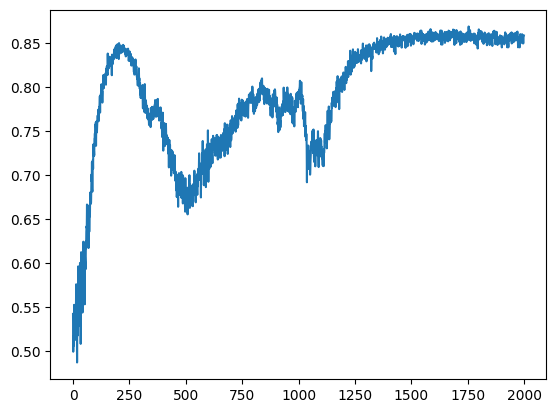

In [41]:
plt.clf()
plt.gca().set_aspect('auto')
plt.plot(carry[-2][:])
plt.show()

In [ ]:
actor = carry[0]

[4 2]


  0%|          | 0/200 [00:00<?, ?it/s]

0.0 0.865


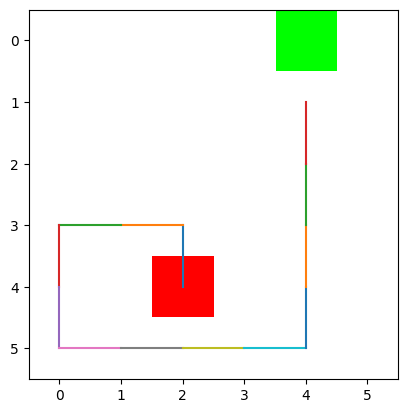

In [51]:
from utils.render import save_frames_as_gif

from IPython.display import Image
from tqdm.notebook import tqdm
import gym

import numpy as np

# agent = PPORNNDiscrete(gae_estimator(discount, 0.95), clip_ratio, ppo_steps)

actor = carry[0]

key = jax.random.PRNGKey(74)

c = nn.OptimizedLSTMCell(hidden_size, parent=None).initialize_carry(key, (1, hidden_size))
done = jnp.ones((1, 1, 1))

obs, state = env.reset(key, env_params)

last_pos = state.pos

print(last_pos)

vis = env.visualize_state(state)

plt.imshow(vis)

positions = [last_pos]

r = 0

frames = []
for t in tqdm(range(200)):
    
    c, action = agent.suggest_action(jnp.expand_dims(obs, (0, 1)), c, jnp.reshape(done, (1, 1)), actor)
    action = action.item()

    # print(action)

    # plt.imshow(env.visualize_obs(jnp.reshape(obs, (3, 3, 3))))
    # plt.show()
    
    obs, state, reward, done, _ = env.step(key, state, action, env_params)

    if done:
        break

    plt.plot([last_pos[1], state.pos[1]], [last_pos[0], state.pos[0]])
    last_pos = state.pos

    r += reward

    positions.append(last_pos)

    # break

print(r, reward)
plt.show()

In [ ]:
obs[:, :, 2]

In [ ]:
state.pos

In [ ]:
plt.imshow(env.visualize_obs(jnp.reshape(obs, (3, 3, 3))))
plt.show()

In [ ]:
done

In [ ]:
plt.imshow(vis)
plt.plot([0, 5], [2, 2])